<a href="https://colab.research.google.com/github/SD325/NASA_Internship_2020/blob/master/NASA_Only_Precip_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Imports
import joblib
import pickle
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


# Working Directory 
BASE_DIR = '/content/drive/My Drive/data/NASA_2020/'

# Prepare Data

## Read Data

In [3]:
BASE_DIR = '/content/drive/My Drive/data/NASA_2020/'
# fall (280), winter (13), spring (92), summer (157)
filenames =['colloc_Precipflag_DPR_GMI_20151007.sav',
            'colloc_Precipflag_DPR_GMI_20160113.sav',
            'colloc_Precipflag_DPR_GMI_20160401.sav']
            #,'colloc_Precipflag_DPR_GMI_20170606.sav']
day_of_year = [280.0, 13.0, 92.0] #, 157]
FILE_PATHS = [BASE_DIR + fn for fn in filenames]
data = [scipy.io.readsav(filepath, verbose=1) for filepath in FILE_PATHS]

--------------------------------------------------
Date: Sat Jun 27 00:49:52 2020
User: jgong
Host: gs613-cirrus.ndc.nasa.gov
--------------------------------------------------
Format: 12
Architecture: x86_64
Operating System: linux
IDL Version: 8.7.3
--------------------------------------------------
Successfully read 14 records of which:
 - 1 are of type VERSION
 - 11 are of type VARIABLE
 - 1 are of type TIMESTAMP
--------------------------------------------------
Available variables:
 - tc [<class 'numpy.ndarray'>]
 - latc [<class 'numpy.ndarray'>]
 - lonc [<class 'numpy.ndarray'>]
 - utc [<class 'numpy.ndarray'>]
 - emis [<class 'numpy.ndarray'>]
 - emis_std [<class 'numpy.ndarray'>]
 - ts [<class 'numpy.ndarray'>]
 - clwp [<class 'numpy.ndarray'>]
 - twv [<class 'numpy.ndarray'>]
 - tysfc [<class 'numpy.ndarray'>]
 - pflag [<class 'numpy.ndarray'>]
--------------------------------------------------
--------------------------------------------------
Date: Fri Jun 26 15:53:36 2020


## Trim Data

In [4]:
data_trimmed = []
for i, data_i in enumerate(data):
  data_trimmed_i = {}
  for var, arr in data_i.items():
    if arr.ndim == 1:
      data_trimmed_i[var] = arr[1:] 
    else:
      data_trimmed_i[var] = arr[1:, 25:196] if arr.ndim == 2 else arr[1:, 25:196, :] 

  for var, arr in data_trimmed_i.items():
    print(f"{var}: {arr.shape}")
  print('-' * 15)
  data_trimmed.append(data_trimmed_i)

# free up memory
del data

tc: (47380, 171, 13)
latc: (47380, 171)
lonc: (47380, 171)
utc: (47380,)
emis: (47380, 171, 13)
emis_std: (47380, 171, 13)
ts: (47380, 171)
clwp: (47380, 171)
twv: (47380, 171)
tysfc: (47380, 171)
pflag: (47380, 171)
---------------
tc: (47370, 171, 13)
latc: (47370, 171)
lonc: (47370, 171)
utc: (47370,)
emis: (47370, 171, 13)
emis_std: (47370, 171, 13)
ts: (47370, 171)
clwp: (47370, 171)
twv: (47370, 171)
tysfc: (47370, 171)
pflag: (47370, 171)
---------------
tc: (47407, 171, 13)
latc: (47407, 171)
lonc: (47407, 171)
utc: (47407,)
emis: (47407, 171, 13)
emis_std: (47407, 171, 13)
ts: (47407, 171)
clwp: (47407, 171)
twv: (47407, 171)
tysfc: (47407, 171)
pflag: (47407, 171)
---------------


## Polarization Differences (PDs)

In [5]:
# calculate polarization differences (PD)
def add_to_PD_i(i, freq, ind1, ind2, data):
  PD[i][freq] = data[i]['tc'][:, :, ind1] - data[i]['tc'][:, :, ind2]

PD = [{} for _ in range(len(data_trimmed))]
for i in range(len(data_trimmed)):
  add_to_PD_i(i, '10.65', 0, 1, data_trimmed)
  add_to_PD_i(i, '18.70', 2, 3, data_trimmed)
  add_to_PD_i(i, '36.50', 5, 6, data_trimmed)
  add_to_PD_i(i, '89.00', 7, 8, data_trimmed)
  add_to_PD_i(i, '166.0', 9, 10, data_trimmed)
  print(PD[i].keys())

dict_keys(['10.65', '18.70', '36.50', '89.00', '166.0'])
dict_keys(['10.65', '18.70', '36.50', '89.00', '166.0'])
dict_keys(['10.65', '18.70', '36.50', '89.00', '166.0'])


## Construct DataFrame

In [6]:
# # create 2d version of time data
# time_2d = []
# for data_trimmed_i in data_trimmed:
#   time_2d.append(np.tile(data_trimmed_i['utc'][:, np.newaxis], (1, data_trimmed_i['pflag'].shape[1])))
#   print(time_2d[-1].shape)

In [7]:
# ravel 2d data --> scans one after another
'''
* 13 channels TB
* 3 channels PD (10.65, 89 and 166 GHz)
x Surface emissivity
* Ts
* CLWP
* TWV
* Lat/Lon
- Day of the year starting from the first day of the year (i.e., Julian day. For example, 1/1/2017 is 1, 2/1/2017 is 32)
'''
data_dfs = []

# PD_freqs_append = ['10.65', '89.00', '166.0']
PD_freqs_append = ['89.00', '166.0']
data_2d = {'latc': 'lat',
           'lonc': 'lon',
           'ts': 'ts',
           'clwp': 'clwp',
           'twv': 'twv'}
for i, data_i in enumerate(data_trimmed):
  curr_df = pd.DataFrame()
  # # utc (time)
  # curr_df['utc'] = np.ravel(time_2d[i])
  
  # 2d data
  for data_name, df_name in data_2d.items():
    curr_df[df_name] = np.ravel(data_i[data_name])

  # day of year
  curr_df['day_of_year'] = np.repeat(day_of_year[i], curr_df['lat'].size)

  # PDs
  for freq in PD_freqs_append:
    curr_df[f'PD_{freq}'] = np.ravel(PD[i][freq])

  # 3d data
  for idx in range(data_i['tc'].shape[2]):
    curr_df[f'tc_{idx}'] = np.ravel(data_i['tc'][:, :, idx])

  data_dfs.append(curr_df)
  del curr_df


print('combining DataFrames')
data_df = pd.concat(data_dfs, ignore_index = True)
data_df.head()

combining DataFrames


,lat,lon,ts,clwp,twv,day_of_year,PD_89.00,PD_166.0,tc_0,tc_1,tc_2,tc_3,tc_4,tc_5,tc_6,tc_7,tc_8,tc_9,tc_10,tc_11,tc_12
0,-68.794342,121.109978,-99.0,-99.0,-99.0,280.0,14.330002,10.839996,228.770004,205.880005,223.490005,204.559998,222.809998,224.610001,208.850006,231.000000,216.669998,227.389999,216.550003,237.830002,230.470001
1,-68.736092,121.270271,-99.0,-99.0,-99.0,280.0,13.979996,12.560013,229.369995,204.470001,222.880005,203.619995,223.070007,224.199997,208.869995,230.679993,216.699997,228.960007,216.399994,237.610001,231.130005
2,-68.716942,121.389320,-99.0,-99.0,-99.0,280.0,14.509995,9.139999,228.990005,204.149994,223.880005,203.710007,223.369995,224.240005,208.160004,231.479996,216.970001,227.419998,218.279999,238.160004,231.839996
3,-68.697197,121.507530,-99.0,-99.0,-99.0,280.0,14.410004,10.429993,228.979996,203.429993,223.240005,202.210007,222.839996,224.020004,205.979996,231.139999,216.729996,226.339996,215.910004,237.490005,231.080002
4,-68.648026,121.535782,-99.0,-99.0,-99.0,280.0,14.319992,10.379990,228.630005,204.619995,223.919998,202.509995,222.520004,223.520004,206.960007,230.789993,216.470001,228.259995,217.880005,238.449997,231.389999


In [8]:
del data_dfs
# del time_2d
del PD

In [9]:
y = pd.DataFrame()
y['pflag'] = np.concatenate(tuple(np.ravel(data_trimmed[i]['pflag']).byteswap().newbyteorder() for i in range(len(data_trimmed))))
del data_trimmed
y.head()

,pflag
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN


## Drop Unwanted (Only Precipitating Pixels)

In [10]:
X_dropped = data_df[(~np.isnan(y['pflag'])) & (data_df['ts'] != -99.0) & (~np.isnan(data_df['twv']))]
X_dropped.head()

,lat,lon,ts,clwp,twv,day_of_year,PD_89.00,PD_166.0,tc_0,tc_1,tc_2,tc_3,tc_4,tc_5,tc_6,tc_7,tc_8,tc_9,tc_10,tc_11,tc_12
405,-65.898605,125.724609,258.322540,0.011064,2.236660,280.0,15.860001,7.970001,255.880005,226.380005,246.889999,221.880005,246.110001,244.300003,222.809998,235.240005,219.380005,229.220001,221.250000,246.289993,242.410004
406,-65.805023,125.751350,258.579742,0.014423,2.670216,280.0,16.639999,8.400009,253.389999,224.309998,242.050003,215.660004,239.710007,241.649994,220.169998,236.690002,220.050003,230.100006,221.699997,246.559998,244.940002
407,-65.758141,125.762604,258.836304,0.017788,2.518587,280.0,17.520004,9.369995,252.440002,221.479996,237.250000,211.589996,237.020004,238.259995,216.669998,236.710007,219.190002,231.639999,222.270004,246.270004,244.490005
408,-65.711205,125.772438,259.092346,0.021157,2.816634,280.0,17.740005,8.839996,251.350006,219.380005,237.149994,211.309998,236.559998,239.070007,218.169998,236.779999,219.039993,232.750000,223.910004,245.880005,245.850006
409,-65.664230,125.780869,259.347931,0.024527,2.969014,280.0,18.130005,9.139999,248.699997,219.960007,238.360001,211.179993,237.539993,239.399994,217.750000,238.830002,220.699997,234.940002,225.800003,245.990005,247.029999


In [11]:
print(y.shape)
y_dropped = y[(~np.isnan(y['pflag'])) & (data_df['ts'] != -99.0) & (~np.isnan(data_df['twv']))]
print(y_dropped.shape)

(24308847, 1)
(2185776, 1)


In [12]:
X_dropped = X_dropped[(y_dropped['pflag'] == 1.0) | (y_dropped['pflag'] == 2.0)]
y_dropped = y_dropped[(y_dropped['pflag'] == 1.0) | (y_dropped['pflag'] == 2.0)]
y_dropped

,pflag
941,1.0
942,1.0
1271,2.0
3843,1.0
3846,1.0
...,...
24196425,2.0
24196601,2.0
24196602,2.0
24196940,2.0


In [13]:
# convert to binary outputs
y_dropped['pflag'] -= 1.0
y_dropped

,pflag
941,0.0
942,0.0
1271,1.0
3843,0.0
3846,0.0
...,...
24196425,1.0
24196601,1.0
24196602,1.0
24196940,1.0


In [14]:
del data_df
del y

## Data Exploration (Overlapping Pixels)

In [15]:
# X_pos_time = X_dropped[['utc', 'lat', 'lon']]
# X_pos_time.shape

In [16]:
# coords_set = set()
# for row in X_pos_time.iterrows():
#   coords_set.add((round(row[1]['lat'], 3), round(row[1]['lon'], 3)))
#   # if i > 5:
#   #   break
#   # print(row[1]['utc'])
#   # print(row[1]['lat'])
#   # print(row[1]['lon'])
#   # print('-----')
# print(len(coords_set))

In [17]:
# del coords_set
# del X_pos_time

## Scale (Numerical) & One-Hot Encode (Categorical) Data

In [18]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_prep = scaler.fit_transform(X_dropped)
X_prep.shape

(62422, 21)

In [19]:
# from sklearn.preprocessing import OneHotEncoder
# ohe = OneHotEncoder()
# y_prep = ohe.fit_transform(y_dropped).toarray()
y_prep = np.array(y_dropped['pflag'])
y_prep.shape

(62422,)

In [20]:
del X_dropped
del y_dropped

In [21]:
# should be all zeros
print("X: ", sum(np.isnan(X_prep)))
print("y: ", sum(np.isnan(y_prep)))

X:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
y:  0


## Save Data

In [22]:
with open(BASE_DIR + 'X_data_3_days_binary_precip_type.pkl', 'wb') as f:
  pickle.dump(X_prep, f)
  del X_prep

with open(BASE_DIR + 'y_data_3_days_binary_precip_type.pkl', 'wb') as f:
  pickle.dump(y_prep, f)
  del y_prep

# Load and Split Data

In [23]:
with open(BASE_DIR + 'X_data_3_days_binary_precip_type.pkl', 'rb') as f:
  X = pickle.load(f)
  print(f'Loaded X. {X.shape}')

with open(BASE_DIR + 'y_data_3_days_binary_precip_type.pkl', 'rb') as f:
  y = pickle.load(f)
  print(f'Loaded y. {y.shape}')

Loaded X. (62422, 21)
Loaded y. (62422,)


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
del X
del y
print(f"train: {X_train.shape} {y_train.shape}")
print(f"test: {X_test.shape} {y_test.shape}")

train: (49937, 21) (49937,)
test: (12485, 21) (12485,)


In [25]:
y_train

array([0., 0., 0., ..., 0., 0., 0.])

# Under Sampling

In [26]:
# # original counts
# from collections import Counter
# orig_counts = Counter(y_train)
# print("original: ", orig_counts)

original:  Counter({0.0: 46260, 1.0: 3677})


In [27]:
# from imblearn.over_sampling import SMOTE

# resampling_dict = {x_: orig_counts[0.0] for x_ in orig_counts}
# sampler = SMOTE(resampling_dict, random_state=42)
# X_res, y_res = sampler.fit_sample(X_train, y_train)
# print(X_res.shape, y_res.shape)

(92520, 21) (92520,)


In [28]:
# print("original: ", Counter(y_train))
# print("resampled: ", Counter(y_res))

original:  Counter({0.0: 46260, 1.0: 3677})
resampled:  Counter({0.0: 46260, 1.0: 46260})


# Random Forest

In [29]:
# Random Forest Hyperparameters
n_estimators = 300
max_depth = 15
bootstrap = True
criterion = 'entropy'
class_weight = 'balanced'
random_state = 42
n_job = -1

In [30]:
rfc = RandomForestClassifier(n_estimators=n_estimators, bootstrap=bootstrap, criterion=criterion,
                                  max_depth=max_depth, oob_score=False, verbose=2,
                                  class_weight=class_weight, random_state=random_state, n_jobs=n_job)

rfc.fit(X_res, y_res)

building tree 1 of 300
building tree 2 of 300


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 3 of 300
building tree 4 of 300
building tree 5 of 300
building tree 6 of 300
building tree 7 of 300
building tree 8 of 300
building tree 9 of 300
building tree 10 of 300
building tree 11 of 300
building tree 12 of 300
building tree 13 of 300
building tree 14 of 300
building tree 15 of 300
building tree 16 of 300
building tree 17 of 300
building tree 18 of 300
building tree 19 of 300
building tree 20 of 300
building tree 21 of 300building tree 22 of 300

building tree 23 of 300
building tree 24 of 300
building tree 25 of 300
building tree 26 of 300
building tree 27 of 300
building tree 28 of 300
building tree 29 of 300
building tree 30 of 300
building tree 31 of 300
building tree 32 of 300
building tree 33 of 300
building tree 34 of 300
building tree 35 of 300
building tree 36 of 300
building tree 37 of 300
building tree 38 of 300


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   19.3s


building tree 39 of 300
building tree 40 of 300
building tree 41 of 300
building tree 42 of 300
building tree 43 of 300
building tree 44 of 300
building tree 45 of 300
building tree 46 of 300
building tree 47 of 300
building tree 48 of 300
building tree 49 of 300
building tree 50 of 300
building tree 51 of 300
building tree 52 of 300
building tree 53 of 300
building tree 54 of 300
building tree 55 of 300
building tree 56 of 300
building tree 57 of 300
building tree 58 of 300
building tree 59 of 300
building tree 60 of 300
building tree 61 of 300
building tree 62 of 300
building tree 63 of 300
building tree 64 of 300
building tree 65 of 300
building tree 66 of 300
building tree 67 of 300
building tree 68 of 300
building tree 69 of 300
building tree 70 of 300
building tree 71 of 300
building tree 72 of 300
building tree 73 of 300
building tree 74 of 300
building tree 75 of 300
building tree 76 of 300
building tree 77 of 300
building tree 78 of 300
building tree 79 of 300
building tree 80

[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.3min


building tree 161 of 300
building tree 162 of 300
building tree 163 of 300
building tree 164 of 300
building tree 165 of 300
building tree 166 of 300
building tree 167 of 300
building tree 168 of 300
building tree 169 of 300
building tree 170 of 300
building tree 171 of 300
building tree 172 of 300
building tree 173 of 300
building tree 174 of 300
building tree 175 of 300
building tree 176 of 300
building tree 177 of 300
building tree 178 of 300
building tree 179 of 300
building tree 180 of 300
building tree 181 of 300
building tree 182 of 300
building tree 183 of 300
building tree 184 of 300
building tree 185 of 300
building tree 186 of 300
building tree 187 of 300
building tree 188 of 300
building tree 189 of 300
building tree 190 of 300
building tree 191 of 300
building tree 192 of 300
building tree 193 of 300
building tree 194 of 300
building tree 195 of 300
building tree 196 of 300
building tree 197 of 300
building tree 198 of 300
building tree 199 of 300
building tree 200 of 300


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.5min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='entropy',
                       max_depth=15, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=300, n_jobs=-1, oob_score=False,
                       random_state=42, verbose=2, warm_start=False)

## Save and Load Model

In [31]:
# save trained model
joblib.dump(rfc, BASE_DIR + 'random_forest_binary_precip_3_days.model')

['/content/drive/My Drive/data/NASA_2020/random_forest_binary_precip_3_days.model']

In [32]:
# load existing model
rfc = joblib.load(BASE_DIR + 'random_forest_binary_precip_3_days.model')

In [33]:
rfc.verbose = False
y_pred = rfc.predict(X_test)
y_pred

array([0., 0., 0., ..., 0., 1., 1.])

In [34]:
y_probs = rfc.predict_proba(X_test)
y_probs

array([[0.95065002, 0.04934998],
       [0.93929223, 0.06070777],
       [0.97599131, 0.02400869],
       ...,
       [0.98842858, 0.01157142],
       [0.16733197, 0.83266803],
       [0.05250985, 0.94749015]])

In [35]:
y_pred_probs = y_probs[:, 1]
print(y_pred_probs)

[0.04934998 0.06070777 0.02400869 ... 0.01157142 0.83266803 0.94749015]


## Confusion Matrix

In [36]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

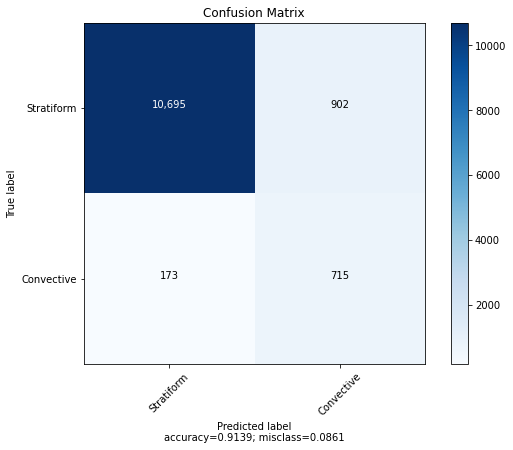

In [37]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm           = conf_mat, 
                      normalize    = False,
                      target_names = ['Stratiform', 'Convective'],
                      title        = "Confusion Matrix")

## ROC Curves

0.9424509445204452


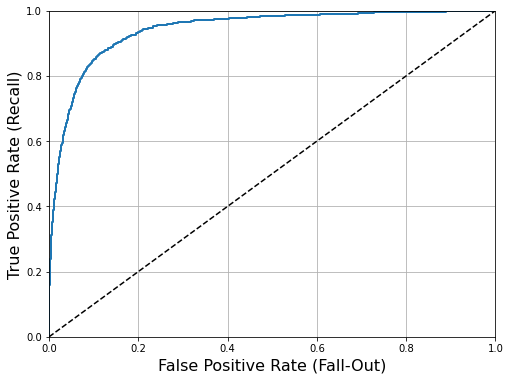

In [38]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)
    plt.grid(True)                                        


print(roc_auc_score(y_test, y_pred_probs))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
plt.figure(figsize=(8, 6)) 
plot_roc_curve(fpr, tpr)         
plt.show()

## Feature Importances

21


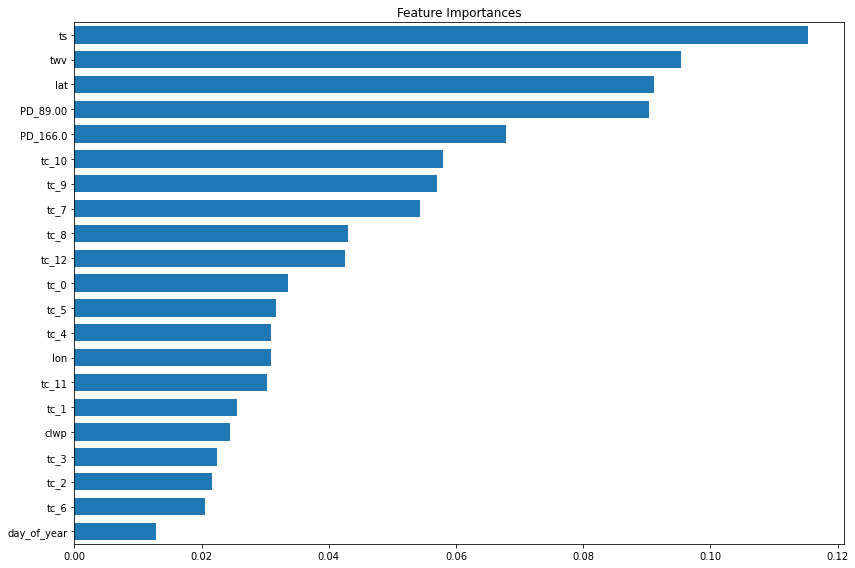

In [39]:
# feature_names = np.array(['lat', 'lon',	'ts',	'clwp',	'twv', 'day_of_year', 'PD_10.65',	'PD_89.00',	'PD_166.0', 'tc_0', 'tc_1',	'tc_2', 'tc_3', 'tc_4',	'tc_5',	'tc_6',	'tc_7',	'tc_8',	'tc_9',	'tc_10', 'tc_11', 'tc_12'])
feature_names = np.array(['lat', 'lon',	'ts',	'clwp',	'twv', 'day_of_year', 'PD_89.00',	'PD_166.0', 'tc_0', 'tc_1',	'tc_2', 'tc_3', 'tc_4',	'tc_5',	'tc_6',	'tc_7',	'tc_8',	'tc_9',	'tc_10', 'tc_11', 'tc_12'])
print(len(feature_names))
tree_importance_sorted_idx = np.argsort(rfc.feature_importances_)
tree_indices = np.arange(0, len(rfc.feature_importances_)) + 0.5
fig, (ax1) = plt.subplots(1, 1, figsize=(12, 8))
ax1.barh(tree_indices,
         rfc.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticklabels(feature_names[tree_importance_sorted_idx])
ax1.set_yticks(tree_indices)
ax1.set_ylim((0, len(rfc.feature_importances_)))
plt.title('Feature Importances')
fig.tight_layout()
plt.show()

In [40]:
del X_res
del y_res
del X_test
del y_test

# Testing: 20170606 File

In [41]:
FILE_PATH = BASE_DIR + 'colloc_Precipflag_DPR_GMI_20170606.sav'
data = scipy.io.readsav(FILE_PATH, verbose=1)
for var, arr in data.items():
  print(f"{var}: {arr.shape}")

--------------------------------------------------
Date: Fri Jun 26 14:43:54 2020
User: jgong
Host: gs613-cirrus.ndc.nasa.gov
--------------------------------------------------
Format: 12
Architecture: x86_64
Operating System: linux
IDL Version: 8.7.3
--------------------------------------------------
Successfully read 14 records of which:
 - 1 are of type VERSION
 - 11 are of type VARIABLE
 - 1 are of type TIMESTAMP
--------------------------------------------------
Available variables:
 - tc [<class 'numpy.ndarray'>]
 - latc [<class 'numpy.ndarray'>]
 - lonc [<class 'numpy.ndarray'>]
 - utc [<class 'numpy.ndarray'>]
 - emis [<class 'numpy.ndarray'>]
 - emis_std [<class 'numpy.ndarray'>]
 - ts [<class 'numpy.ndarray'>]
 - clwp [<class 'numpy.ndarray'>]
 - twv [<class 'numpy.ndarray'>]
 - tysfc [<class 'numpy.ndarray'>]
 - pflag [<class 'numpy.ndarray'>]
--------------------------------------------------
tc: (44425, 221, 13)
latc: (44425, 221)
lonc: (44425, 221)
utc: (44425,)
emis: (44

## Trim Data

In [42]:
data_trimmed = {}
for var, arr in data.items():
  if arr.ndim == 1:
    data_trimmed[var] = arr[1:] 
  else:
    data_trimmed[var] = arr[1:, 25:196] if arr.ndim == 2 else arr[1:, 25:196, :] 

for var, arr in data_trimmed.items():
  print(f"{var}: {arr.shape}")

# free up memory
del data

tc: (44424, 171, 13)
latc: (44424, 171)
lonc: (44424, 171)
utc: (44424,)
emis: (44424, 171, 13)
emis_std: (44424, 171, 13)
ts: (44424, 171)
clwp: (44424, 171)
twv: (44424, 171)
tysfc: (44424, 171)
pflag: (44424, 171)


## Polarization Differences (PDs)

In [43]:
# calculate polarization differences (PD)
def add_to_PD(freq, ind1, ind2, data):
  PD[freq] = data['tc'][:, :, ind1] - data['tc'][:, :, ind2]

PD = {}
add_to_PD('10.65', 0, 1, data_trimmed)
add_to_PD('18.70', 2, 3, data_trimmed)
add_to_PD('36.50', 5, 6, data_trimmed)
add_to_PD('89.00', 7, 8, data_trimmed)
add_to_PD('166.0', 9, 10, data_trimmed)
print(PD.keys())

dict_keys(['10.65', '18.70', '36.50', '89.00', '166.0'])


## Construct DataFrame

In [44]:
# ravel 2d data --> scans one after another
'''
* 13 channels TB
* 3 channels PD (10.65, 89 and 166 GHz)
x Surface emissivity
* Ts
* CLWP
* TWV
* Lat/Lon
- Day of the year starting from the first day of the year (i.e., Julian day. For example, 1/1/2017 is 1, 2/1/2017 is 32)
'''
# data_dfs = []

# PD_freqs_append = ['10.65', '89.00', '166.0']
PD_freqs_append = ['89.00', '166.0']
data_2d = {'latc': 'lat',
           'lonc': 'lon',
           'ts': 'ts',
           'clwp': 'clwp',
           'twv': 'twv'}

data_df = pd.DataFrame()
# # utc (time)
# curr_df['utc'] = np.ravel(time_2d[i])

# 2d data
for data_name, df_name in data_2d.items():
  data_df[df_name] = np.ravel(data_trimmed[data_name])

# day of year
data_df['day_of_year'] = np.repeat(157.0, data_df['lat'].size)

# PDs
for freq in PD_freqs_append:
  data_df[f'PD_{freq}'] = np.ravel(PD[freq])

# 3d data
for idx in range(data_trimmed['tc'].shape[2]):
  data_df[f'tc_{idx}'] = np.ravel(data_trimmed['tc'][:, :, idx])

# data_dfs.append(curr_df)
# del curr_df


# print('combining DataFrames')
# data_df = pd.concat(data_dfs, ignore_index = True)
data_df.head()

,lat,lon,ts,clwp,twv,day_of_year,PD_89.00,PD_166.0,tc_0,tc_1,tc_2,tc_3,tc_4,tc_5,tc_6,tc_7,tc_8,tc_9,tc_10,tc_11,tc_12
0,-61.262722,-49.823647,-99.0,-99.0,-99.0,157.0,8.110001,2.419983,222.300003,174.649994,231.169998,193.610001,235.429993,238.149994,211.759995,254.389999,246.279999,264.049988,261.630005,252.940002,261.170013
1,-61.310246,-49.962563,-99.0,-99.0,-99.0,157.0,15.250000,1.470001,212.520004,159.190002,217.690002,167.339996,225.220001,230.940002,194.199997,254.550003,239.300003,263.019989,261.549988,253.279999,259.709991
2,-61.321098,-50.057407,-99.0,-99.0,-99.0,157.0,20.430008,4.459991,204.029999,146.410004,207.300003,149.770004,218.029999,226.020004,180.679993,252.740005,232.309998,263.519989,259.059998,252.559998,260.179993
3,-61.366501,-50.097477,-99.0,-99.0,-99.0,157.0,26.729996,3.619995,199.279999,139.000000,203.759995,145.809998,215.550003,223.580002,176.380005,249.259995,222.529999,262.260010,258.640015,253.940002,260.359985
4,-61.379467,-50.191345,-99.0,-99.0,-99.0,157.0,23.729996,5.030029,200.050003,141.229996,205.940002,149.240005,217.690002,225.679993,180.610001,250.669998,226.940002,262.140015,257.109985,252.940002,261.010010


In [45]:
y = pd.DataFrame()
y['pflag'] = np.ravel(data_trimmed['pflag']).byteswap().newbyteorder()
del data_trimmed
del PD
y.head()

,pflag
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN


## Drop Unwanted (Only Precipitating Pixels)

In [46]:
X_dropped = data_df[(~np.isnan(y['pflag'])) & (data_df['ts'] != -99.0) & (~np.isnan(data_df['twv']))]
X_dropped.head()

,lat,lon,ts,clwp,twv,day_of_year,PD_89.00,PD_166.0,tc_0,tc_1,tc_2,tc_3,tc_4,tc_5,tc_6,tc_7,tc_8,tc_9,tc_10,tc_11,tc_12
6219,-63.970222,-44.958664,269.916016,0.069215,7.392964,157.0,13.149994,2.550003,245.919998,199.479996,236.410004,196.220001,233.960007,223.070007,193.190002,227.559998,214.410004,252.880005,250.330002,252.550003,260.859985
6220,-64.060516,-45.017330,269.917816,0.070007,7.295566,157.0,19.000000,5.559998,246.220001,197.250000,236.199997,192.419998,231.759995,223.720001,191.770004,226.539993,207.539993,250.630005,245.070007,253.000000,260.149994
6221,-64.105881,-45.044941,269.924072,0.071173,7.393708,157.0,14.860001,6.599991,245.429993,196.779999,235.919998,188.669998,232.839996,223.850006,195.279999,223.919998,209.059998,251.309998,244.710007,252.990005,259.760010
6256,-65.920784,-45.132149,270.087494,0.144744,8.787667,157.0,10.250000,2.050003,252.619995,225.490005,245.110001,214.339996,241.229996,228.350006,208.919998,224.759995,214.509995,248.699997,246.649994,248.740005,257.279999
6257,-65.966667,-45.107044,270.080017,0.146130,8.735859,157.0,10.630005,2.980011,253.080002,228.050003,246.460007,216.509995,244.440002,231.550003,211.410004,227.520004,216.889999,247.820007,244.839996,249.250000,257.329987


In [47]:
print(y.shape)
y_dropped = y[(~np.isnan(y['pflag'])) & (data_df['ts'] != -99.0) & (~np.isnan(data_df['twv']))]
print(y_dropped.shape)

(7596504, 1)
(667630, 1)


In [48]:
X_dropped = X_dropped[(y_dropped['pflag'] == 1.0) | (y_dropped['pflag'] == 2.0)]
y_dropped = y_dropped[(y_dropped['pflag'] == 1.0) | (y_dropped['pflag'] == 2.0)]
y_dropped

,pflag
205266,1.0
205272,1.0
205273,1.0
205437,1.0
205608,1.0
...,...
7383186,1.0
7383332,2.0
7383522,1.0
7586168,1.0


In [49]:
# convert to binary outputs
y_dropped['pflag'] -= 1.0
y_dropped

,pflag
205266,0.0
205272,0.0
205273,0.0
205437,0.0
205608,0.0
...,...
7383186,0.0
7383332,1.0
7383522,0.0
7586168,0.0


In [50]:
del data_df
del y

## Scale (Numerical) & One-Hot Encode (Categorical) Data

In [51]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_prep = scaler.fit_transform(X_dropped)
X_prep.shape

(27136, 21)

In [52]:
# from sklearn.preprocessing import OneHotEncoder
# ohe = OneHotEncoder()
# y_prep = ohe.fit_transform(y_dropped).toarray()
y_prep = np.array(y_dropped['pflag'])
y_prep.shape

(27136,)

In [53]:
del X_dropped
del y_dropped

In [54]:
# should be all zeros
print("X: ", sum(np.isnan(X_prep)))
print("y: ", sum(np.isnan(y_prep)))

X:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
y:  0


## Test Model

In [55]:
rfc.verbose = False
y_pred = rfc.predict(X_prep)
y_pred

array([0., 0., 0., ..., 0., 0., 0.])

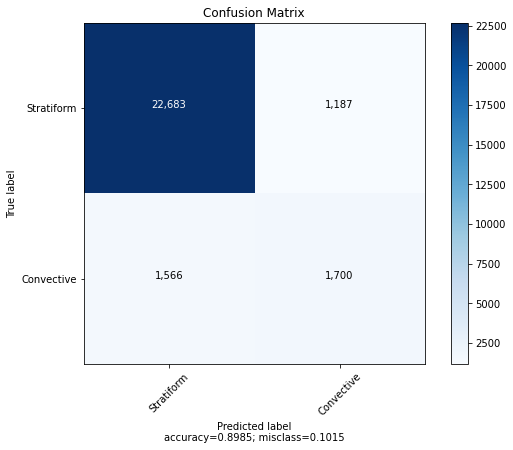

In [56]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_prep, y_pred)

plot_confusion_matrix(cm           = conf_mat, 
                      normalize    = False,
                      target_names = ['Stratiform', 'Convective'],
                      title        = "Confusion Matrix")

In [57]:
y_probs = rfc.predict_proba(X_prep)
y_pred_probs = y_probs[:, 1]
y_pred_probs

array([0.17095915, 0.14686894, 0.14645883, ..., 0.11168587, 0.19111937,
       0.18502772])

0.8544660414354033


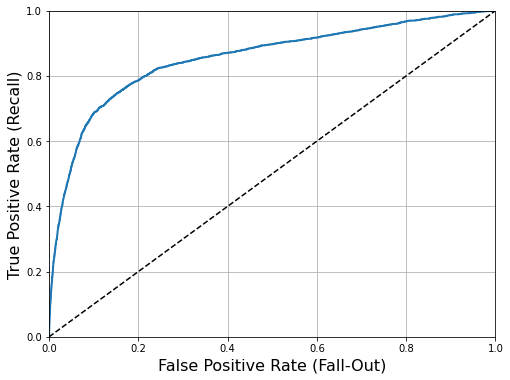

In [58]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)
    plt.grid(True)                                        


print(roc_auc_score(y_prep, y_pred_probs))
fpr, tpr, thresholds = roc_curve(y_prep, y_pred_probs)
plt.figure(figsize=(8, 8)) 
plot_roc_curve(fpr, tpr)         
plt.show()